# **MDI 230 Project Vélib**

**Noms:**

Lola MAGNARD \\
Lucas SOUSA \\
Wilmar QUIROGA

On considère un système de vélos partagés, type Vélib, où les vélos sont disponibles dans des stations dédiées et peuvent être empruntés pour faire des trajets d’une station à une autre. Le but de ce projet est
de calculer les probabilités stationnaires

### Link to run the code in Google Colab \\
[Google Colab](https://colab.research.google.com/drive/1dS6h2txPL0l3HP33M8ga6HlhdDCh09vR?usp=sharing)




# 4. Simulation



##Question 3 :  Simulez les trajectoires du processus de Markov



[[26.  0.  0.  0.  0.]
 [ 0. 12.  0.  0.  0.]
 [ 0.  0. 20.  0.  0.]
 [ 0.  0.  0.  7.  0.]
 [ 0.  1.  0.  0. 25.]]


<Figure size 432x288 with 0 Axes>

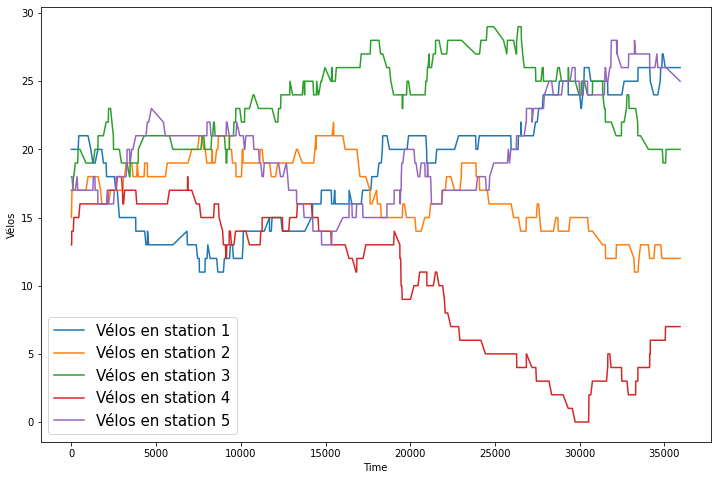

In [4]:
import numpy as np
from numpy.random import binomial
import numpy.random as rd
import matplotlib.pyplot as plt
from numba import jit
from matplotlib import pyplot
from IPython import get_ipython

Tau = 60*np.array([[0,3,5,7,7],
                   [2,0,2,5,5],
                   [4,2,0,3,3],
                   [8,6,4,0,2],
                   [7,7,5,2,0]]) # En secondes

Ns = 5; # Nombre de Stations

# L’intensité de départs de la station i par seconde:
Lambda_i = 1/3600 * np.array([2.8, 3.7, 5.5, 3.5, 4.6]) # Taux de départ par seconde

# Probabilite Routage
p_routage = np.array([[0.  ,0.22,0.32,0.2 ,0.26],
                      [0.17,0   ,0.34,0.21,0.28],
                      [0.19,0.26,0   ,0.24,0.31],
                      [0.17,0.22,0.33,0   ,0.28],
                      [0.18,0.24,0.35,0.23,0   ]])

lambdas_i = np.array([2.8, 3.7, 5.5, 3.5, 4.6])/3600

# Conditions Initiales
n0  = np.array([20,15,17,13,18]) # Nombre de vélos dans chaque station ni
nt0 = np.array([[0,1,0,0,0],
                [1,0,1,0,0],
                [0,1,0,1,0],
                [0,0,1,0,1],
                [0,0,0,1,0]]) # Nombre de vélos par trajets n_{t_ij}

nts = np.zeros((Ns,Ns)) # Nombre de vélos dans chaque station ni et chaque trajet n_{t_ij}
nts = nt0 + n0*np.eye(Ns)

# Le paramètre de la loi exponentielle qui régit le temps entre
# les départs de la station i pour aller en station j:
Lambda_depart = np.zeros((Ns,Ns))
# Paramètres de calibration
for i in range(len(p_routage)):
    for j in range(len(Lambda_depart)):
        Lambda_depart[i,j] = Lambda_i[i]*p_routage[i,j]

# Le paramètre de la loi exponentielle qui régit
# le temps de trajet entre la station i et la station j:
Lambda_trajet = np.zeros((Ns,Ns))
for i in range(Ns):
    for j in range(Ns):
        if i != j:
            Lambda_trajet[i,j] = 1/Tau[i,j]
 

#Functions de taux de transitions 
@jit
def choose_transition(Nvs,lambdaj):
    state=np.copy(Nvs)
    lambdajkD=np.zeros((Ns,Ns))
    lambdajkA=np.zeros((Ns,Ns))
    for i in range(Ns):
        for j in range(Ns):
            if  (state[i,i]>0) and (i!=j):
                lambdajkD[i,j]=Lambda_depart[i,j]
            if  (i!=j):
                lambdajkA[i,j]=Lambda_trajet[i,j]*state[i,j]   
            
    r_trajet=lambdajkA/lambdaj
    r_depart=lambdajkD/lambdaj
    u=np.random.rand()

    # Transitions 
    Pt=0; #Sum de probabilites
    for i in range(Ns):
        for j in range(Ns):
            if(i!=j):
                Pt+=r_depart[i,j]
                if (Pt>u):
                    state[i,j]+=1
                    state[i,i]-=1;
                    break
                Pt+=r_trajet[i,j]
                if  (Pt>u):
                    state[i,j]-=1
                    state[j,j]+=1
                    break
        if (Pt>u):
            break

    return state 
    
            
def MarkovProcessus(t): #Temps en heures 
    states=np.copy(nts)
    time=t*3600 #Temps en secondes
    Temps=0 #Vecteur de temps 
    tempT=0
    #Vecteurs de trajectoires pour chaque station[1,5] Etats Initial n0
    NVstationN=np.copy(n0)
     
    while(time>tempT): 
        lambdaj=0 # C'est la somme de tous les lambdas des departs et des trajets
        for i in range(Ns):
            for j in range(Ns):
                lambdaj+=Lambda_trajet[i,j]* states[i,j]
                lambdaj+=Lambda_depart[i,j]*(states[i,i] > 0)
        
        # T variable aleatoire
        SejourT=np.random.exponential(1/lambdaj)
    
        tempT+=SejourT
        if tempT > time:
          break
        Temps=np.append(Temps,tempT)

        states=choose_transition(states,lambdaj)
        n_station=np.diag(states)
        
        NVstationN = np.vstack((NVstationN, n_station))# Ajouter le nouveau état à chaque station             
        
    
    return NVstationN[:,0],NVstationN[:,1],NVstationN[:,2],NVstationN[:,3],NVstationN[:,4],Temps,states
    

def PrintMarkov(t, retour=False):
    Station1,Station2,Station3,Station4,Station5,T,st=MarkovProcessus(t);
    pyplot.clf()
    pyplot.figure(figsize=(12, 8))
    pyplot.plot(T,Station1, label = 'Vélos en station 1')
    pyplot.plot(T,Station2, label = 'Vélos en station 2')
    pyplot.plot(T,Station3, label = 'Vélos en station 3')
    pyplot.plot(T,Station4, label = 'Vélos en station 4')
    pyplot.plot(T,Station5, label = 'Vélos en station 5')
    pyplot.ylabel('Vélos')
    pyplot.xlabel('Time')
    pyplot.legend(fontsize=15)
    print(st)
    if retour:
      return Station1,Station2,Station3,Station4,Station5,T,st
    
    
PrintMarkov(10)

## Question 4:

En déduire la probabilité que chaque station soit vide après 150 heures.



In [ ]:
n_station = []
for i in range(200):
    S1,S2,S3,S4,S5,T,st=MarkovProcessus(150)
    n_station.append(np.diag(st))

n_station = np.array(n_station)

prob = np.mean(n_station == 0, axis=0)

In [ ]:
for i in range(Ns):
  print(f"La probabilité que la station {i+1} soit vide est de {prob[i]:.3f} = {100*prob[i]:.2f}%")

La probabilité que la station 1 soit vide est de 0.005 = 0.50%
La probabilité que la station 2 soit vide est de 0.040 = 4.00%
La probabilité que la station 3 soit vide est de 0.180 = 18.00%
La probabilité que la station 4 soit vide est de 0.020 = 2.00%
La probabilité que la station 5 soit vide est de 0.085 = 8.50%


## Question 5:
Calculer l’intervalle de confiance de ce résultat.

Sélon les consignes, "on rappelle que l’intervalle de confiance d’une quantité $\theta = E[X]$ estimée sur $n$ tirages $X_1, ... , X_n$ de moyenne $\hat{\theta}_n = \frac{1}{n} \sum_{i=1}^{n}X_i$ est l’intervalle de la forme $[
\hat{\theta}_n − \epsilon, \hat{\theta}_n + \epsilon]$ dans lequel on est sûr à $\alpha%$ que se trouve $\theta$. On a $\epsilon = \beta \sigma_n/\sqrt{n}$ avec :

- $\sigma_n$ l’écart-type empririque sur les tirages;
- $\beta = 1.96$ pour $\alpha = 0.95$.

In [ ]:
ecart_ci = 1.96 * np.sqrt(np.var(n_station, axis=0)/200)

for i in range(Ns):
  print(f"L'intervale de confiance de la probabilité que la station {i+1} soit vide est ]{np.clip(100*prob[i]-ecart_ci[i], 0, 100):.3f}%, {100*prob[i]+ecart_ci[i]:.3f}%[")

L'intervale de confiance de la probabilité que la station 1 soit vide est ]0.000%, 3.672%[
L'intervale de confiance de la probabilité que la station 2 soit vide est ]2.923%, 7.077%[
L'intervale de confiance de la probabilité que la station 3 soit vide est ]15.172%, 16.828%[
L'intervale de confiance de la probabilité que la station 4 soit vide est ]2.740%, 7.260%[
L'intervale de confiance de la probabilité que la station 5 soit vide est ]6.194%, 8.806%[


# 5. Calcul théorique

## Question 6
Utilisez les équations de trafic pour obtenir les relations entre les $α_i$
(notations du document sur les colonies).

$$\alpha_j > 0$$  
$$\sum_{j} α_j = 1$$  
Dans une colonie représentant une station on a que le nombre de vélo qui entre est la somme des vélos provenant de toutes les routes d'entré tandis que le nombre de vélo qui sortent est égal à la somme des vélos empruntant toutes les routes de sortie, soit

$$\alpha_j \sum_{k=1, k\neq j}^K \lambda_{j, t_{jk}} = \sum_{k=1, k\neq j}^K \alpha_{t_{kj}} \lambda_{t_{kj},j}$$

avec $\alpha_j$ étant la distribution d'équilibre pour une station $j$, $\alpha_{t_{kj}}$ la distribution d'équilibre pour un trajet sortant d'une station $k$ vers la station $j$

Pour une colonie représentant les routes, le nombre de vélos entrant est égal au nombre de vélos sortants, soit:

$$\alpha_{t_{jk}}λ_{t_{jk},k} = \alpha_j \lambda_{j,t_{jk}}$$

Où les $\alpha$ doivent satisfaire: 

$$\forall j, \forall k, \alpha_j > 0 \textrm{ et } \alpha_{t_{jk}} > 0$$ et

$$\sum_{j,k=1, j \neq k}^K \alpha_{t_{jk}} + \sum_{j=1}^K \alpha_j = 1$$

On peut reécrire la deuxième équation et remplacer le terme à gauche dans la première equation, en échangeant $j$ et $k$:

$$\alpha_{t_{jk}} = \alpha_j \frac{\lambda_{j, t_{jk}}}{\lambda_{t_{jk},k}}$$

$$\alpha_j \sum_{k=1}^K \lambda_{j, t_{jk}} = \sum_{k=1}^K \alpha_k \frac{\lambda_{k, t_{kj}}}{\lambda_{t_{kj},j}} \lambda_{t_{kj},j}$$

$$\alpha_j \sum_{k=1}^K \lambda_{j, t_{jk}} = \sum_{k=1}^K \alpha_k \lambda_{k, t_{kj}} $$

Cette nouvelle équation ne dépend pas des distributions d'équilibre dans les états de trajet. 

$$\alpha_j \sum_{k=1}^K \lambda_{j, t_{jk}} - \sum_{k=1}^K \alpha_k \lambda_{k, t_{kj}} = 0$$

On peut résoudre le système pour trouver les $\alpha_j$, ensuite on utilise la relation qu'on a trouvé entre les valeurs de $\alpha_{jk}$. Finalement, on normalise les valeurs de $\alpha$ pour respecter la contrainte $\sum \alpha = 1$. On donne plus de détails dans la question 9.

## Question 7
On considère qu’il n’y a qu’un seul vélo, quelle est alors la taille de
l’espace d’état ?


On a $5^2$ colonies possibles (5 stations et 20 trajets entre eux).

Chaque état dans l'espace d'états est écrit donc comme $n = (n_1, ..., n_{25})$, où $n_i$ est le nombre de vélos dans une colonie $i$. Pour un seul vélo, les possibilités sont toujours d'avoir un vélo dans une colonie et zéro vélos dans toutes les autres, alors la t aille de l'espace d'état est 25.

## Question 8
Dans ces conditions (un seul vélo), calculer la probabilité que chaque
station soit vide.

La probabilité qu'une station soit vide correspond à $1$ moins la probabilité qu'il y ait au moins un vélo dans la station. Dans ces condition (un seul vélo), c'est en fait $1$ moins la probabilité qu'il y ait exactement un vélo dans la station. 

$$P(n_j = 0) = 1 - P(n_j = 1)$$

Selon le theorème $2.4$ du document sur le Modèle des Colonies disponibilisé, la distribution d'équilibre pour un processus fermé de migration est donné par:

$$ \pi(n) = G_N^{-1} \prod_{j=1}^J { \frac{\alpha_j^{n_j}}{\prod_{r=1}^{n_j}{\phi_j(r)}} }, n \in S$$

où $G_N$ est une constante de normalisation pour que la somme des distributions soit 1. Comme ça, pour un seul vélo, on obtient:

$$P(n_j = 0) = 1 - P(n_j = 1) = 1 - G_N^{-1}\alpha_j$$
$$G_N^{-1}\sum_{j=1}^J \alpha_j = 1 \implies G_N = \sum_{j=1}^J \alpha_j$$

Donc, on a besoin des valeurs de $\alpha$ trouvés ensuite à la question 9. On reviendra à ce point après ces calculs.

## Question 9
Comparez aux résultats obtenus par simulation.

Pour résoudre numériquement le système d’équations donnant les $α_i$,
on suggère de mettre le système sous forme de calcul matriciel $M α = X$
où α est le vecteur colonne des $α_i$. On a alors $α = M^{−1}X$.  
Pour éviter$X = 0$, on pourra remplacer une ligne de $M$ par des $1$, on a en effet $n + 1$ équations pour $n$ inconnues si on ajoute la condition de normalisation.

On peut écrire l'équation finale de la question 6 forme matricielle $M\alpha = 0$, où:

- La diagonale de $M$ est le terme qui multiplie $\alpha_j$ pour chaque $j$: $M_{j,j} = \sum_{k=1}^K \lambda_{j,t_{jk}}$

- Les autres éléments de $M$ sont les termes qui multiplient chaque $\alpha_k$: $M_{j,k, j\neq k} = -\lambda_{k, t_{kj}}$

In [3]:
M = np.zeros((Ns,Ns))

for j in range(Ns):
  for k in range(Ns):
    if j == k:
      M[j,k] = np.sum(Lambda_depart[j,:])
    else:
      M[j,k] = -Lambda_depart[k,j]

_M = np.copy(M)
_M[0,:] = 1

b = np.zeros(Ns)
_b = np.copy(b)
_b[0] = 1

alpha_jj = np.linalg.solve(_M,_b)

Pour résoudre les équations avec une solution autre que la solution triviale, on remplace une ligne par un vecteur de 1s. On trouve les valeurs $\alpha_j$, mais il nous manque les valeurs de $\alpha_{t_{jk}}$. Pour les trouver, on utilise la relation qu'on a trouvé entre ces valeurs. Finalement, on normalise les valeurs de $\alpha$ pour respecter la contrainte $\sum \alpha = 1$.

In [4]:
alpha = alpha_jj * np.eye(Ns)

for j in range(Ns):
  for k in range(Ns):
    if j != k:
      alpha[j,k] = alpha_jj[j] * Lambda_depart[j,k]/Lambda_trajet[j,k]

alpha /= np.sum(alpha)
print(alpha)

[[0.16782957 0.00516915 0.01253127 0.01096487 0.01425432]
 [0.00337868 0.16114533 0.00675736 0.01043416 0.01391221]
 [0.0098917  0.006768   0.14198607 0.00937108 0.01210431]
 [0.01281105 0.01243426 0.01243426 0.16148385 0.00527514]
 [0.01447881 0.01930507 0.02010945 0.00528591 0.14988411]]


On peut finalement calculer les probabilités que chaque station soit vide dans le cas d'un seul vélo.

In [5]:
for i in range(Ns):
  print("La probabilité théorique que la station", i+1, "soit vide est de", f"{1-alpha[i,i]:.4f}")

La probabilité théorique que la station 1 soit vide est de 0.8322
La probabilité théorique que la station 2 soit vide est de 0.8389
La probabilité théorique que la station 3 soit vide est de 0.8580
La probabilité théorique que la station 4 soit vide est de 0.8385
La probabilité théorique que la station 5 soit vide est de 0.8501


On doit enfin comparer ces résultats au résultat obtenu dans la simulation:

In [ ]:
n0  = np.array([1,0,0,0,0]) # Nombre de vélos dans chaque station n_i
nt0 = np.array([[0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0],
                [0,0,0,0,0]]) # Nombre de vélos par trajets n_{t_ij}

nts = np.zeros((Ns,Ns)) # Nombre de vélos dans chaque station ni et chaque trajet n_{t_ij}
nts = nt0 + n0*np.eye(Ns)

n_station = []
for i in range(200):
  S1,S2,S3,S4,S5,T,st = MarkovProcessus(150)
  n_station.append(np.diag(st))

n_station = np.array(n_station)

prob = np.mean(n_station == 0, axis=0)

for i in range(Ns):
  print("La probabilité empirique que la station", i+1, "soit vide est de", f"{prob[i]:.4f} = {100*prob[i]:.2f}%")

La probabilité empirique que la station 1 soit vide est de 0.8300 = 83.00%
La probabilité empirique que la station 2 soit vide est de 0.8200 = 82.00%
La probabilité empirique que la station 3 soit vide est de 0.8600 = 86.00%
La probabilité empirique que la station 4 soit vide est de 0.8550 = 85.50%
La probabilité empirique que la station 5 soit vide est de 0.8200 = 82.00%


In [ ]:
ecart_ci = 1.96 * np.sqrt(np.var(n_station, axis=0)/200)

for i in range(Ns):
  print(f"L'intervalle de confiance de la probabilité que la station {i+1} soit vide est ]{np.clip(100*prob[i]-ecart_ci[i], 0, 100):.3f}%, {100*prob[i]+ecart_ci[i]:.3f}%[")

L'intervalle de confiance de la probabilité que la station 1 soit vide est ]82.948%, 83.052%[
L'intervalle de confiance de la probabilité que la station 2 soit vide est ]81.947%, 82.053%[
L'intervalle de confiance de la probabilité que la station 3 soit vide est ]85.952%, 86.048%[
L'intervalle de confiance de la probabilité que la station 4 soit vide est ]85.451%, 85.549%[
L'intervalle de confiance de la probabilité que la station 5 soit vide est ]81.947%, 82.053%[


Les résultats théoriques ne sont pas dans l'intervalle de confiance à 95% de l'estimateur, mais ils sont très proches, avec un erreur souvent moins grand qu'un point de pourcentage.

# 6) Simulation pour 100 vélos

## Question 10:

Simuler le même réseau avec 100 vélos, initialement répartis de façon uniforme entre les stations et les routes.


Ici nous simulons le réseau dans une période de 10 heures pour avoir une meilleur visualiation du résultat, mais on peut voir après le graphe les résultats de la simulation dans une période de 150 heures, comme dans les question précedentes.

[[33.  0.  0.  0.  0.]
 [ 0. 19.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.]
 [ 0.  0.  0. 22.  0.]
 [ 0.  0.  1.  0. 21.]]


<Figure size 432x288 with 0 Axes>

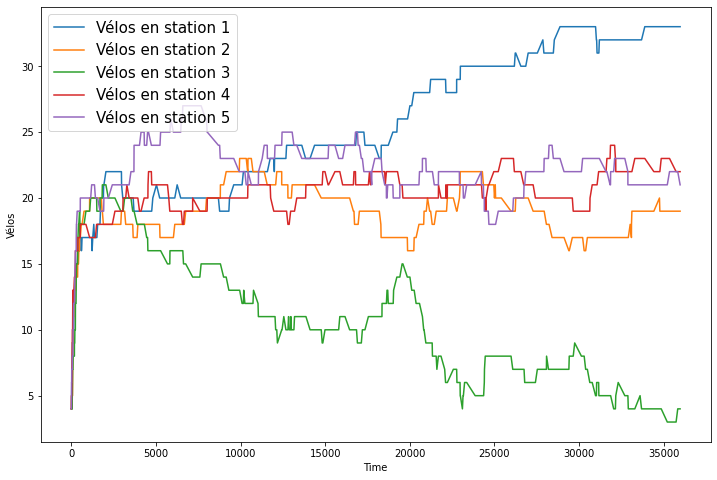

In [ ]:
n = 100/(Ns**2)
n0 = n*np.ones(Ns)
nts = n*np.ones((Ns,Ns))

PrintMarkov(10)

In [ ]:
n_station = []
for i in range(200):
  S1,S2,S3,S4,S5,T,st = MarkovProcessus(150)
  n_station.append(np.diag(st))

n_station = np.array(n_station)

prob = np.mean(n_station == 0, axis=0)

for i in range(Ns):
  print("La probabilité empirique que la station", i+1, "soit vide est de", f"{prob[i]:.4f} = {100*prob[i]:.2f}%")

ecart_ci = 1.96 * np.sqrt(np.var(n_station, axis=0)/200)

for i in range(Ns):
  print(f"L'intervalle de confiance de la probabilité que la station {i+1} soit vide est ]{np.clip(100*prob[i]-ecart_ci[i], 0, 100):.3f}%, {100*prob[i]+ecart_ci[i]:.3f}%[")

La probabilité empirique que la station 1 soit vide est de 0.0200 = 2.00%
La probabilité empirique que la station 2 soit vide est de 0.0250 = 2.50%
La probabilité empirique que la station 3 soit vide est de 0.1600 = 16.00%
La probabilité empirique que la station 4 soit vide est de 0.0150 = 1.50%
La probabilité empirique que la station 5 soit vide est de 0.0750 = 7.50%
L'intervalle de confiance de la probabilité que la station 1 soit vide est ]0.000%, 4.810%[
L'intervalle de confiance de la probabilité que la station 2 soit vide est ]0.190%, 4.810%[
L'intervalle de confiance de la probabilité que la station 3 soit vide est ]15.198%, 16.802%[
L'intervalle de confiance de la probabilité que la station 4 soit vide est ]0.000%, 3.968%[
L'intervalle de confiance de la probabilité que la station 5 soit vide est ]6.236%, 8.764%[


## Question 11: 

Calculer la probabilité stationnaire que chaque station soit vide par
la méthode décrite en section 7.4. On n’oubliera pas de préciser
l’intervalle de confiance.